In [23]:
# Load pyspark
import findspark

findspark.init()

#import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession, functions as F, window

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler, Bucketizer
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

import datetime
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

spark = SparkSession.builder.appName("dengue").getOrCreate()

### Chargement des données pré-traitées

In [2]:
df_train = spark.read.parquet("data/01-preprocessed")

print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))

df_train = (1456, 24)


### Construction de nouvelles variables

#### Végétation

NDVI Normalized difference vegetation index (NDVI) indique l'indice de végétation :
- en dessous de -0.1 il s'agit probablement d'eau
- entre -0.1 et 0.1 urbanisé ou pierre ou minéral ou terre nue
- entre 0.1 et 0.4 végétation peu dense
- au dessus de 0.4 végétation dense


(à noter que les seuils ne sont pas toujours très bien définis...)

In [3]:
def bucketize(df):
    splits = [-float("inf"), -0.1, 0.1, 0.4, float("inf")]

    bucketizer_ne = Bucketizer(splits=splits, inputCol='ndvi_ne', outputCol='bucket_ne')
    bucketizer_nw = Bucketizer(splits=splits, inputCol='ndvi_nw', outputCol='bucket_nw')
    bucketizer_sw = Bucketizer(splits=splits, inputCol='ndvi_sw', outputCol='bucket_sw')
    bucketizer_se = Bucketizer(splits=splits, inputCol='ndvi_se', outputCol='bucket_se')
    
    # Transform original data into its bucket index.
    df = bucketizer_ne.transform(df)
    df = bucketizer_nw.transform(df)
    df = bucketizer_sw.transform(df)
    df = bucketizer_se.transform(df)
    
    return df

df_train = bucketize(df_train)

df_train.select(['bucket_ne', 'bucket_nw', 'bucket_sw', 'bucket_se']) \
    .show()

+---------+---------+---------+---------+
|bucket_ne|bucket_nw|bucket_sw|bucket_se|
+---------+---------+---------+---------+
|      2.0|      2.0|      2.0|      2.0|
|      2.0|      2.0|      2.0|      2.0|
|      1.0|      2.0|      2.0|      2.0|
|      2.0|      2.0|      2.0|      2.0|
|      2.0|      2.0|      2.0|      2.0|
|      2.0|      2.0|      2.0|      2.0|
|      2.0|      1.0|      2.0|      2.0|
|      1.0|      1.0|      2.0|      2.0|
|      2.0|      2.0|      2.0|      2.0|
|      2.0|      2.0|      2.0|      2.0|
|      2.0|      1.0|      2.0|      2.0|
|      2.0|      2.0|      2.0|      2.0|
|      2.0|      2.0|      2.0|      2.0|
|      2.0|      2.0|      2.0|      2.0|
|      2.0|      1.0|      2.0|      2.0|
|      2.0|      2.0|      2.0|      2.0|
|      2.0|      2.0|      2.0|      2.0|
|      2.0|      2.0|      2.0|      2.0|
|      2.0|      2.0|      2.0|      2.0|
|      2.0|      3.0|      2.0|      2.0|
+---------+---------+---------+---

### Matrice de corrélation

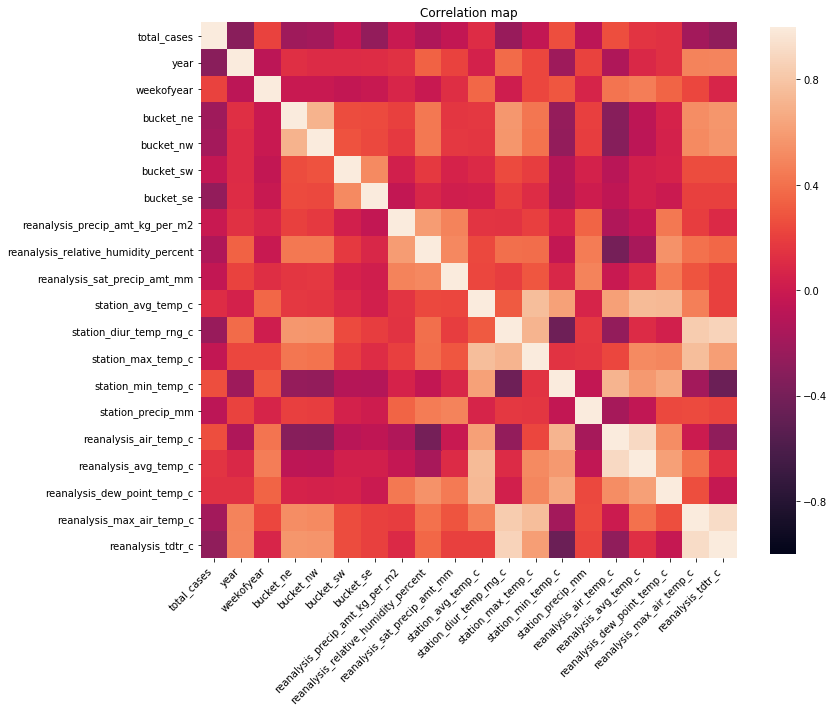

In [21]:
# convert to vector column first
vector_col = "features"
col_names = ['total_cases',
             'year', 'weekofyear',
             'bucket_ne', 'bucket_nw', 'bucket_sw', 'bucket_se',
             'reanalysis_precip_amt_kg_per_m2',
             'reanalysis_relative_humidity_percent',
             'reanalysis_sat_precip_amt_mm',
#             'reanalysis_specific_humidity_g_per_kg',
             'station_avg_temp_c',
             'station_diur_temp_rng_c',
             'station_max_temp_c', 'station_min_temp_c',
             'station_precip_mm',
             'reanalysis_air_temp_c',
             'reanalysis_avg_temp_c',
             'reanalysis_dew_point_temp_c',
             'reanalysis_max_air_temp_c',
#             'reanalysis_min_air_temp_c',
             'reanalysis_tdtr_c'
             ]

assembler = VectorAssembler(inputCols=col_names, outputCol=vector_col)

# all
df = df_train
df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)
array = matrix.collect()[0]["pearson({})".format(vector_col)].values

# convert (small) correlation matrix to pandas dataframe for visualization
corr_df = pd.DataFrame(
    np.reshape(array, (len(col_names), len(col_names))),
    index=col_names,
    columns=col_names)

# make plot
fig = plt.figure(figsize=(12, 10))
plt.title('Correlation map')

ax = sns.heatmap(corr_df, square=True,
                 xticklabels=True, yticklabels=True,
                 vmin=-1.0, vmax=1.0,
                 cbar_kws={"shrink": .97})

ax.set_xticklabels(ax.get_xticklabels(), rotation=45.0,
                   horizontalalignment='right')

# to fix bug in sns.heatmap (matplotlib 3.11)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

In [28]:
def compute_lags(df_train):
    # build a window
    w = window.Window() \
        .partitionBy('city') \
        .orderBy(F.col('week_start_date'))

    print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))

    # add new columns with different lags
    df_train = df_train \
        .withColumn('ndvi_ne_1', F.lag('ndvi_ne', count=1).over(w)) \
        .withColumn('ndvi_ne_2', F.lag('ndvi_ne', count=2).over(w)) \
        .withColumn('ndvi_ne_3', F.lag('ndvi_ne', count=3).over(w)) \
        .withColumn('ndvi_ne_4', F.lag('ndvi_ne', count=4).over(w)) \
        .withColumn('ndvi_nw_1', F.lag('ndvi_nw', count=1).over(w)) \
        .withColumn('ndvi_nw_2', F.lag('ndvi_nw', count=2).over(w)) \
        .withColumn('ndvi_nw_3', F.lag('ndvi_nw', count=3).over(w)) \
        .withColumn('ndvi_nw_4', F.lag('ndvi_nw', count=4).over(w)) \
        .withColumn('ndvi_sw_1', F.lag('ndvi_sw', count=1).over(w)) \
        .withColumn('ndvi_sw_2', F.lag('ndvi_sw', count=2).over(w)) \
        .withColumn('ndvi_sw_3', F.lag('ndvi_sw', count=3).over(w)) \
        .withColumn('ndvi_sw_4', F.lag('ndvi_sw', count=4).over(w)) \
        .withColumn('ndvi_se_1', F.lag('ndvi_se', count=1).over(w)) \
        .withColumn('ndvi_se_2', F.lag('ndvi_se', count=2).over(w)) \
        .withColumn('ndvi_se_3', F.lag('ndvi_se', count=3).over(w)) \
        .withColumn('ndvi_se_4', F.lag('ndvi_se', count=4).over(w)) \

    print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))
    return df_train

df_train = compute_lags(df_train)
# we drop the four first rows 
df_train = df_train.dropna()
print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))
#df_train.show()

df_train = (1440, 60)
df_train = (1440, 60)
df_train = (1432, 60)


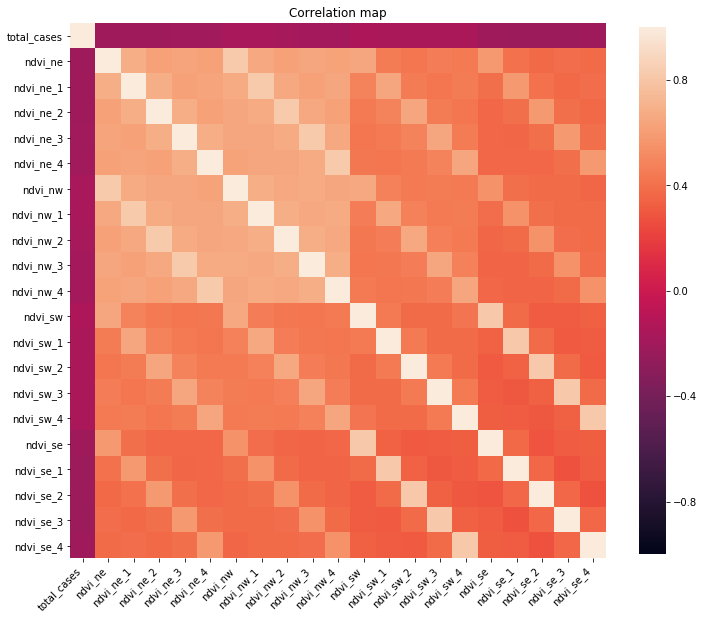

In [29]:
# convert to vector column first
vector_col = "features"
col_names = ['total_cases',
             'ndvi_ne', 'ndvi_ne_1', 'ndvi_ne_2', 'ndvi_ne_3', 'ndvi_ne_4',
             'ndvi_nw', 'ndvi_nw_1', 'ndvi_nw_2', 'ndvi_nw_3', 'ndvi_nw_4', 
             'ndvi_sw', 'ndvi_sw_1', 'ndvi_sw_2', 'ndvi_sw_3', 'ndvi_sw_4',
             'ndvi_se', 'ndvi_se_1', 'ndvi_se_2', 'ndvi_se_3', 'ndvi_se_4'
             ]

assembler = VectorAssembler(inputCols=col_names, outputCol=vector_col)

# all
df = df_train
df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)
array = matrix.collect()[0]["pearson({})".format(vector_col)].values

# convert (small) correlation matrix to pandas dataframe for visualization
corr_df = pd.DataFrame(
    np.reshape(array, (len(col_names), len(col_names))),
    index=col_names,
    columns=col_names)

# make plot
fig = plt.figure(figsize=(12, 10))
plt.title('Correlation map')

ax = sns.heatmap(corr_df, square=True,
                 xticklabels=True, yticklabels=True,
                 vmin=-1.0, vmax=1.0,
                 cbar_kws={"shrink": .97})

ax.set_xticklabels(ax.get_xticklabels(), rotation=45.0,
                   horizontalalignment='right')

# to fix bug in sns.heatmap (matplotlib 3.11)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

In [ ]:
def compute_lags(df_train):
    # build a window
    w = window.Window() \
        .partitionBy('city') \
        .orderBy(F.col('week_start_date'))

    print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))

    # add new columns with different lags
    df_train = df_train \
        .withColumn('bucket_ne_1', F.lag('bucket_ne', count=1).over(w)) \
        .withColumn('bucket_ne_2', F.lag('bucket_ne', count=2).over(w)) \
        .withColumn('bucket_ne_3', F.lag('bucket_ne', count=3).over(w)) \
        .withColumn('bucket_ne_4', F.lag('bucket_ne', count=4).over(w)) \
        .withColumn('bucket_nw_1', F.lag('bucket_nw', count=1).over(w)) \
        .withColumn('bucket_nw_2', F.lag('bucket_nw', count=2).over(w)) \
        .withColumn('bucket_nw_3', F.lag('bucket_nw', count=3).over(w)) \
        .withColumn('bucket_nw_4', F.lag('bucket_nw', count=4).over(w)) \
        .withColumn('bucket_sw_1', F.lag('bucket_sw', count=1).over(w)) \
        .withColumn('bucket_sw_2', F.lag('bucket_sw', count=2).over(w)) \
        .withColumn('bucket_sw_3', F.lag('bucket_sw', count=3).over(w)) \
        .withColumn('bucket_sw_4', F.lag('bucket_sw', count=4).over(w)) \
        .withColumn('bucket_se_1', F.lag('bucket_se', count=1).over(w)) \
        .withColumn('bucket_se_2', F.lag('bucket_se', count=2).over(w)) \
        .withColumn('bucket_se_3', F.lag('bucket_se', count=3).over(w)) \
        .withColumn('bucket_se_4', F.lag('bucket_se', count=4).over(w)) \

    print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))
    return df_train

df_train = compute_lags(df_train)
# we drop the four first rows 
df_train = df_train.dropna()
print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))
#df_train.show()

### Construction des jeux d'entrainement et de test

In [4]:
# San Juan
df_train_sj = df_train.filter(df_train.city == 'sj')
min_date_sj, max_date_sj = df_train_sj.select(F.min("week_start_date"),
                                              F.max("week_start_date")).first()

print("San Juan data:")
print("df_train_sj = ({}, {})".format(df_train_sj.count(), len(df_train_sj.columns)))
print("\tdate_start = {} / date_stop = {}".format(min_date_sj, max_date_sj))

# Iquitos
df_train_iq = df_train.filter(df_train.city == 'iq')
min_date_iq, max_date_iq = df_train_iq.select(F.min("week_start_date"),
                                              F.max("week_start_date")).first()

print("Iquitos data:")
print("df_train_iq = ({}, {})".format(df_train_iq.count(), len(df_train_iq.columns)))
print("\tdate_start = {} / date_stop = {}".format(min_date_iq, max_date_iq))

San Juan data:
df_train_sj = (936, 28)
	date_start = 1990-04-30 / date_stop = 2008-04-22
Iquitos data:
df_train_iq = (520, 28)
	date_start = 2000-07-01 / date_stop = 2010-06-25


In [5]:
# split train and test
delta = datetime.timedelta(weeks=52)

# San Juan
cut_date_sj = max_date_sj - delta

train_sj = df_train_sj.filter(df_train_sj.week_start_date <= cut_date_sj)
test_sj = df_train_sj.filter(df_train_sj.week_start_date > cut_date_sj)

print("train_sj = ({}, {})".format(train_sj.count(), len(train_sj.columns)))
print("test_sj = ({}, {})".format(test_sj.count(), len(test_sj.columns)))

# Iquitos
cut_date_iq = max_date_iq - delta

train_iq = df_train_iq.filter(df_train_iq.week_start_date <= cut_date_iq)
test_iq = df_train_iq.filter(df_train_iq.week_start_date > cut_date_iq)

print("train_iq = ({}, {})".format(train_iq.count(), len(train_iq.columns)))
print("test_iq = ({}, {})".format(test_iq.count(), len(test_iq.columns)))

train_sj = (884, 28)
test_sj = (52, 28)
train_iq = (468, 28)
test_iq = (52, 28)


In [6]:
# concatanate the 2 sets
train = train_sj.union(train_iq)
test = test_sj.union(test_iq)

print("train = ({}, {})".format(train.count(), len(train.columns)))
print("test = ({}, {})".format(test.count(), len(test.columns)))

train = (1352, 28)
test = (104, 28)


### Affichage des jeux de données

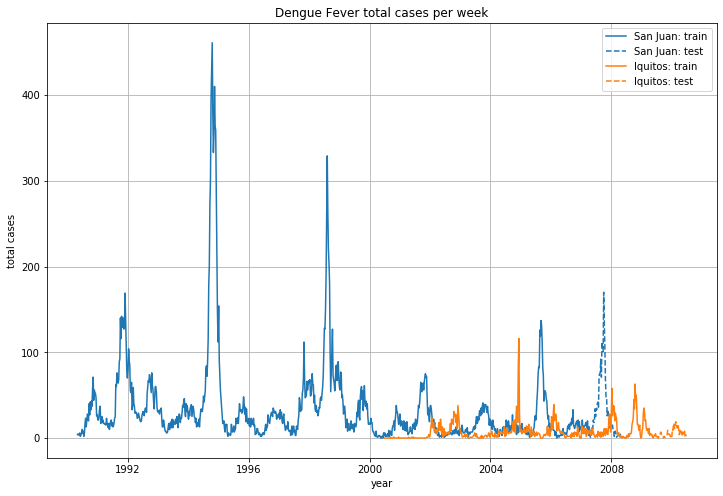

In [7]:
pd_train_sj = train_sj.toPandas()
pd_train_iq = train_iq.toPandas()

pd_test_sj = test_sj.toPandas()
pd_test_iq = test_iq.toPandas()

# Total cases per city
plt.figure(figsize=(12, 8))

plt.grid()
plt.title('Dengue Fever total cases per week')

plt.xlabel('year')
plt.ylabel('total cases')
plt.xticks()
plt.yticks()

p_sj = plt.plot(pd_train_sj['week_start_date'], pd_train_sj['total_cases'],
                label='San Juan: train', linestyle='solid')
plt.plot(pd_test_sj['week_start_date'], pd_test_sj['total_cases'], label='San Juan: test',
         linestyle='dashed', color=p_sj[0].get_color())

p_iq = plt.plot(pd_train_iq['week_start_date'], pd_train_iq['total_cases'],
                label='Iquitos: train', linestyle='solid')
plt.plot(pd_test_iq['week_start_date'], pd_test_iq['total_cases'], label='Iquitos: test',
         linestyle='dashed', color=p_iq[0].get_color())

plt.legend()

plt.show()

### Construction du *pipeline*

In [8]:
# OneHotEncoder categorial variables
indexer = StringIndexer(inputCol='city', outputCol='city_')
encoder = OneHotEncoder(inputCol='city_', outputCol='cityVect')

# Build feature vector
vectorAssembler = VectorAssembler(
    inputCols=['cityVect',
               'year', 'weekofyear',
               'bucket_ne', 'bucket_nw', 'bucket_se', 'bucket_sw',
               'reanalysis_precip_amt_kg_per_m2',
               'reanalysis_relative_humidity_percent',
               'reanalysis_sat_precip_amt_mm',
#               'reanalysis_specific_humidity_g_per_kg',
               'station_avg_temp_c',
               'station_diur_temp_rng_c',
               'station_max_temp_c', 'station_min_temp_c', 
               'station_precip_mm',  
               'reanalysis_air_temp_c',
               'reanalysis_avg_temp_c',
               'reanalysis_dew_point_temp_c',
               'reanalysis_max_air_temp_c',
#               'reanalysis_min_air_temp_c',
               'reanalysis_tdtr_c',
               ], 
    outputCol = 'features')

# scaler
scaler = StandardScaler(inputCol='features',
                        outputCol='scaled_features',
                        withStd=True, withMean=True)

# linear regression
lr = LinearRegression(featuresCol='scaled_features',
                      labelCol='total_cases',
                      predictionCol='lr_prediction')

# Random forest
rf = RandomForestRegressor(featuresCol='scaled_features',
                           labelCol='total_cases',
                           predictionCol='rf_prediction')

### 2. Random Forest

#### 2.1 Simple

In [9]:
pipeline_rf = Pipeline(stages=[indexer, encoder, vectorAssembler, scaler, rf])

evaluator_rf = RegressionEvaluator(labelCol='total_cases',
                                   predictionCol='rf_prediction',
                                   metricName="mae")

# build model
model_rf = pipeline_rf.fit(train)

# Build prediction from 'test' dataset
pred_rf = model_rf.transform(test)

pred_rf.select(['total_cases','rf_prediction']).show(52)

mae = evaluator_rf.evaluate(pred_rf)

print("Random Forest::Before grid search - MAE = {:.3f}".format(mae))

+-----------+------------------+
|total_cases|     rf_prediction|
+-----------+------------------+
|         10|12.287428834161469|
|          8|10.192918974887277|
|         13|12.172389649915576|
|         10| 17.63890295297314|
|         21|  10.3414225451505|
|         18|24.376451172061707|
|         21|18.300182410564744|
|         34|24.008730071023592|
|         25|26.508779254503015|
|         34| 20.24452507429474|
|         33| 21.10348655480318|
|         40| 19.18915485556776|
|         42| 22.73601593454418|
|         36|21.710514281193042|
|         72|42.152698422443976|
|         75| 42.22787340904179|
|         76|24.841953308832107|
|         92|30.343880653613972|
|         71| 43.19054337860845|
|        112|28.305698690152433|
|        106|27.160030342665557|
|        101| 38.58858538443663|
|        170| 32.64817601470643|
|        135|30.427707485006344|
|        106| 36.48605948566451|
|         68|24.576294393141048|
|         48|21.594095617799997|
|         

#### 2.2 Cross-Validation

In [10]:
# Parameter grid for random forest
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [2, 5, 10, 15, 20]) \
    .addGrid(rf.numTrees, [10, 20, 30, 40, 50]) \
    .build()

crossval_rf = CrossValidator(estimator=pipeline_rf,
                             estimatorParamMaps=paramGrid_rf,
                             evaluator=evaluator_rf,
                             numFolds=2,
                             seed=18)

cv_model_rf = crossval_rf.fit(train)

# Build prediction from 'test' dataset
cv_pred_rf = cv_model_rf.transform(test)

mae = evaluator_rf.evaluate(cv_pred_rf)

print("Random Forest::After grid search - MAE = {:.3f}".format(mae))

Random Forest::After grid search - MAE = 15.673


In [11]:
cv_model_rf.bestModel.stages[-1].getNumTrees

20

#### plot

In [ ]:
# create pandas dataframe from spark dataframe
pd_pred_rf = cv_pred_rf.toPandas()

pd_pred_rf_sj = pd_pred_rf[pd_pred_rf['city'] == 'sj']
pd_pred_rf_iq = pd_pred_rf[pd_pred_rf['city'] == 'iq']

In [ ]:
# Total cases per city
plt.figure(figsize=(12, 8))
plt.grid()
plt.title('Random Forest: Prediction Dengue Fever total cases per week')


plt.xlabel('year')
plt.ylabel('total cases')
plt.xticks()
plt.yticks()

plt.plot(pd_train_sj['week_start_date'], pd_train_sj['total_cases'], label='San Juan')
plt.plot(pd_train_iq['week_start_date'], pd_train_iq['total_cases'], label='Iquitos')

plt.plot(pd_pred_rf_sj['week_start_date'], pd_pred_rf_sj['total_cases'], label='Target: San Juan')
plt.plot(pd_pred_rf_iq['week_start_date'], pd_pred_rf_iq['total_cases'], label='Target: Iquitos')

plt.plot(pd_pred_rf_sj['week_start_date'], pd_pred_rf_sj['rf_prediction'], label='Pred: San Juan')
plt.plot(pd_pred_rf_iq['week_start_date'], pd_pred_rf_iq['rf_prediction'], label='Pred: Iquitos')

plt.legend()

plt.show()

In [ ]:
# zoom

# Total cases per city
plt.figure(figsize=(15, 6))

# San Juan
ax1 = plt.subplot(2, 2, 1)
plt.grid()

plt.title('San Juan: Dengue Fever total cases per week')
plt.xlabel('year')
plt.ylabel('total cases')

plt.plot(pd_pred_rf_sj['week_start_date'], pd_pred_rf_sj['total_cases'],
         label='Target')
plt.plot(pd_pred_rf_sj['week_start_date'], pd_pred_rf_sj['rf_prediction'],
         label='Predictions')

plt.legend()

# Iquitos
ax2 = plt.subplot(2, 2, 2)
plt.grid()

plt.title('Iquitos: Dengue Fever total cases per week')
plt.xlabel('year')
plt.ylabel('total cases')

plt.plot(pd_pred_rf_iq['week_start_date'], pd_pred_rf_iq['total_cases'],
         label='Target')
plt.plot(pd_pred_rf_iq['week_start_date'], pd_pred_rf_iq['rf_prediction'],
         label='Predictions')

plt.legend()

plt.show()

## plot LR

### try on test bench

In [ ]:
df_bench = spark.read.parquet("data/preprocessed_bench")

print("df_bench = ({}, {})".format(df_bench.count(), len(df_bench.columns)))

In [ ]:
# simple RF
bench_simple_rf = cv_model_rf.transform(df_bench)

In [ ]:
df_submission = spark.read.csv('data/submission_format.csv',header=True)
df_submission.show(10)

In [ ]:
df_temp = bench_simple_rf['city', 'year', 'weekofyear','rf_prediction']
df_temp = df_temp.withColumn("total_cases", df_temp["rf_prediction"].cast('int'))
df_temp = df_temp.drop('rf_prediction')

In [ ]:
df_temp.show(10)

In [ ]:
df_temp_pandas = df_temp.select('city','year','weekofyear','total_cases').toPandas()
df_temp_pandas_sj = df_temp_pandas[df_temp_pandas['city'] == 'sj']
df_temp_pandas_iq = df_temp_pandas[df_temp_pandas['city'] == 'iq']
df_temp_pandas = pd.concat([df_temp_pandas_sj,df_temp_pandas_iq], axis=0)

In [ ]:
df_temp_pandas.to_csv('data/test_cv_rf.csv',index=False)